In [1]:
from __future__ import unicode_literals
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pickle

In [2]:
MODEL_1 = "finetuned"
MODEL_2 = "irishman"

SET_1_CALCULATED_METRICS_PATH = "data/evaluation/results/{}_vs_{}/{}_calculated_metrics.pkl".format(MODEL_1, MODEL_2, MODEL_1)
SET_2_CALCULATED_METRICS_PATH = "data/evaluation/results/{}_vs_{}/{}_calculated_metrics.pkl".format(MODEL_1, MODEL_2, MODEL_2)

ABSOLUTE_METRICS_STATISTICS_PATH = "data/evaluation/results/{}_vs_{}/absolute_metrics_statistics.pkl".format(MODEL_1, MODEL_2)
RELATIVE_METRICS_STATISTICS_PATH = "data/evaluation/results/{}_vs_{}/relative_metrics_statistics.pkl".format(MODEL_1, MODEL_2)

## Results finetuned vs irishman

Load calculated metrics for each model

In [3]:
with open(SET_1_CALCULATED_METRICS_PATH, "rb") as f:
    set1_loaded_results = pickle.load(f)

with open(SET_2_CALCULATED_METRICS_PATH, "rb") as f:
    set2_loaded_results = pickle.load(f)

display("Set 1 ({}): {} samples".format(MODEL_1, len(set1_loaded_results)))
display("Set 2 ({}): {} samples".format(MODEL_2, len(set2_loaded_results)))

u'Set 1 (finetuned): 9 samples'

u'Set 2 (irishman): 9 samples'

We calculated the following metrics:

**Pitch-based features**
- total_used_pitch
- total_pitch_class_histogram
- pitch_class_transition_matrix
- pitch_range
- avg_pitch_shift

**Rhythm-based features**
- total_used_note
- avg_IOI
- note_length_hist
- note_length_transition_matrix

In [4]:
display(set1_loaded_results.keys())

['total_used_note',
 'note_length_transition_matrix',
 'total_pitch_class_histogram',
 'total_used_pitch',
 'avg_IOI',
 'avg_pitch_shift',
 'pitch_range',
 'pitch_class_transition_matrix',
 'note_length_hist']

# Pitch-based features

## Feature: total_used_pitch

### O que faz:
Esta função conta quantas alturas (pitches) diferentes foram utilizadas em uma música MIDI, medindo a diversidade melódica.

### Como funciona (passo a passo):
1. `piano_roll = feature['pretty_midi'].instruments[0].get_piano_roll(fs=100)`
    - Converte o MIDI em uma matriz piano roll (128 x tempo)
    - 128 linhas = todas as notas possíveis (C0 até G9)
    - Cada coluna = um momento no tempo (100 fps)
    - Valores > 0 = nota está sendo tocada
    
2. `sum_notes = np.sum(piano_roll, axis=1)`
    - Soma cada linha (pitch) ao longo do tempo
    - Resultado: vetor de 128 elementos
    - Cada elemento = tempo total que aquela nota foi tocada

3. `used_pitch = np.sum(sum_notes > 0)`
    - Conta quantas notas tiveram sum > 0
    - Ou seja: quantas alturas diferentes foram usadas na música

### Exemplo prático:
```
Se uma música usa as notas: C4, D4, C4, E4, D4, C4, E3

piano_roll teria valores > 0 apenas nas linhas 52, 60, 62, 64 (MIDI numbers)

sum_notes[52] = tempo total de E3
sum_notes[60] = tempo total de C4
sum_notes[62] = tempo total de D4  
sum_notes[64] = tempo total de E4
sum_notes[outros] = 0

Resultado: total_used_pitch = 4 (quatro alturas diferentes)
```

### Ponto importante:
A função conta alturas únicas, não repetições:

- **C4 repetido 3x** = conta como 1 altura única
- **D4 repetido 2x** = conta como 1 altura única
- **E4 usado 1x** = conta como 1 altura única
- **E3 usado 1x** = conta como 1 altura única

**Total = 4 alturas diferentes**

### Diferença importante:
**total_used_pitch**: Quantas alturas diferentes (foco melódico)
**total_used_note**: Quantos eventos de nota (foco rítmico)
**total_pitch_class_histogram**: Proporção de cada classe (C, C#, D...)

### Interpretação musical:
- **Valores baixos (5-15)**: Melodias simples, poucas notas diferentes
- **Valores médios (20-40)**: Melodias moderadamente complexas
- **Valores altos (50+)**: Melodias muito diversas, muitas alturas diferentes

Esta métrica é útil para comparar a riqueza melódica entre os modelos.

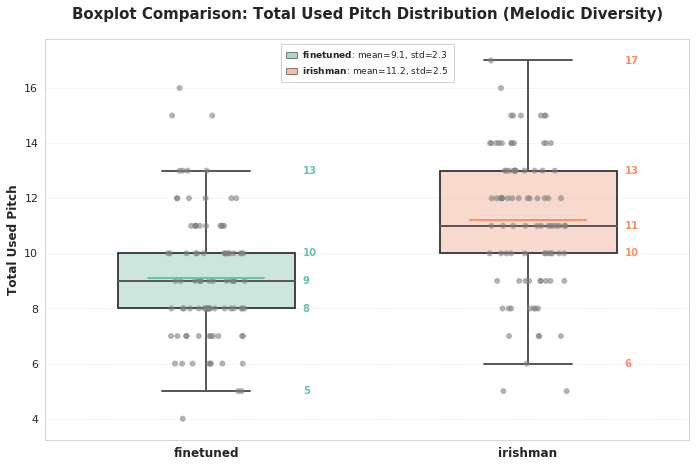

In [12]:
# Dados para total_used_pitch
data1_pitch = set1_loaded_results['total_used_pitch'].flatten()
data2_pitch = set2_loaded_results['total_used_pitch'].flatten()

# Figura e estilo
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style('whitegrid')

# Cores e rótulos
colors = ['#66c2a5', '#fc8d62']
labels = [MODEL_1, MODEL_2]
order = labels
pos_map = {lbl: i for i, lbl in enumerate(order)}

# Dados em formato long
df_pitch = pd.DataFrame({
    'value': np.concatenate([data1_pitch, data2_pitch]),
    'model': np.array([labels[0]] * len(data1_pitch) + [labels[1]] * len(data2_pitch))
})

# Boxplot (sem outliers)
sns.boxplot(x='model', y='value', data=df_pitch, ax=ax, palette=colors,
            width=0.55, showfliers=False, linewidth=2, saturation=0.8,
            order=order)

for artist in ax.artists:
    fc = artist.get_facecolor()
    artist.set_facecolor((fc[0], fc[1], fc[2], 0.35))  # mais transparente
    artist.set_edgecolor('#333333')
    artist.set_linewidth(1.8)

# Pontos (stripplot) com maior visibilidade - em cinza
for lbl, c in zip(labels, colors):
    sns.stripplot(x='model', y='value', data=df_pitch[df_pitch['model'] == lbl], ax=ax,
                  color='gray', size=6.0, jitter=0.12, alpha=0.6, linewidth=0,
                  order=order, zorder=4)

# Linha da média com a cor do box (acima dos pontos)
means_pitch = df_pitch.groupby('model')['value'].mean()
for lbl, c in zip(labels, colors):
    x = pos_map[lbl]
    m = float(means_pitch[lbl])
    ax.plot([x - 0.18, x + 0.18], [m, m], color=c, linewidth=2, alpha=0.95, zorder=5)

# Quartis e limites (whiskers) 1.5*IQR
qstats_pitch = df_pitch.groupby('model')['value'].quantile([0.25, 0.5, 0.75]).unstack()
for lbl, c in zip(labels, colors):
    vals = df_pitch.loc[df_pitch['model'] == lbl, 'value'].values
    q1 = float(qstats_pitch.loc[lbl, 0.25])
    med = float(qstats_pitch.loc[lbl, 0.50])
    q3 = float(qstats_pitch.loc[lbl, 0.75])
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    # whiskers conforme definição do boxplot
    lw = float(np.min(vals[vals >= lower_fence])) if np.any(vals >= lower_fence) else float(np.min(vals))
    uw = float(np.max(vals[vals <= upper_fence])) if np.any(vals <= upper_fence) else float(np.max(vals))

    # Anotações numéricas à direita, mais afastadas do box
    x = pos_map[lbl] + 0.30
    ax.text(x, uw, '{:.0f}'.format(uw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q3, '{:.0f}'.format(q3), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, med, '{:.0f}'.format(med), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q1, '{:.0f}'.format(q1), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, lw, '{:.0f}'.format(lw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)

# Legenda centralizada no topo em 2 linhas
stds_pitch = df_pitch.groupby('model')['value'].std()
# Deixa os nomes dos modelos em negrito na legenda (mathtext \mathbf{})
bold = lambda s: '$\\mathbf{%s}$' % s
label_stats_pitch = [
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[0]), float(means_pitch[labels[0]]), float(stds_pitch[labels[0]])),
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[1]), float(means_pitch[labels[1]]), float(stds_pitch[labels[1]]))
]
handles_pitch = [Patch(facecolor=colors[0], edgecolor='#333333', alpha=0.6),
                 Patch(facecolor=colors[1], edgecolor='#333333', alpha=0.6)]
ax.legend(handles_pitch, label_stats_pitch, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=1,
          frameon=True, framealpha=0.88, borderpad=0.6, fontsize=9,
          handlelength=1.2, handletextpad=0.6, labelspacing=0.45)

# Margens X simétricas ao redor dos dois boxes
ax.set_xlim(-0.5, len(labels) - 0.5)

# Rótulos
ax.set_xlabel('')
ax.set_ylabel('Total Used Pitch', fontsize=12, weight='bold')
ax.set_title('Boxplot Comparison: Total Used Pitch Distribution (Melodic Diversity)', fontsize=15, weight='bold', pad=20)
ax.tick_params(axis='both', which='major', labelsize=11)

for tick in ax.get_xticklabels():
    tick.set_fontsize(12)
    tick.set_fontweight('bold')

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
fig.subplots_adjust(bottom=0.12)
plt.show()

## Feature: total_used_note

### O que faz:
Esta função conta o número total de notas utilizadas em uma música MIDI, focando apenas na quantidade de eventos de nota (aspecto rítmico), não nas alturas específicas.

### Como funciona:
- **Input**: Recebe um `feature` (que contém o padrão MIDI) e `track_num` (número da faixa, padrão = 1)
- **Processo**:
    - Percorre todos os eventos na faixa MIDI especificada
    - Para cada evento, verifica se é um NoteOnEvent (início de nota)
    - Além disso, verifica se `data[1] != 0 (velocity ≠ 0, garantindo que não é um "note off" disfarçado)`
    - Cada nota válida incrementa o contador used_notes
- **Output**: Retorna um escalar representando o número total de notas na música

### Diferença importante:
- `total_used_note`: Conta quantas notas foram tocadas (foco rítmico)
- `total_used_pitch`: Conta quantas alturas/pitches diferentes foram usadas (foco melódico)

### Exemplo prático:
Se uma música tem as notas: C, C, D, C, E
- `total_used_note` = 5 (cinco eventos de nota)
- `total_used_pitch` = 3 (três pitches distintos: C, D, E)

Essa métrica é útil para analisar a densidade rítmica e complexidade temporal das composições geradas pelos diferentes modelos.

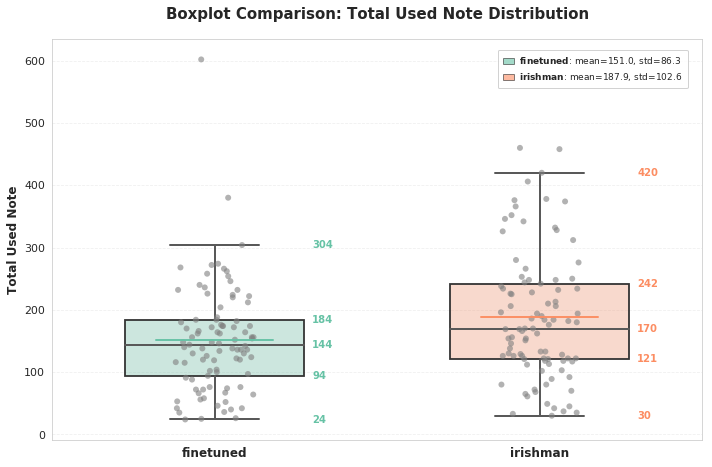

In [13]:
# Dados
data1 = set1_loaded_results['total_used_note'].flatten()
data2 = set2_loaded_results['total_used_note'].flatten()

# Figura e estilo
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style('whitegrid')

# Cores e rótulos
colors = ['#66c2a5', '#fc8d62']
labels = [MODEL_1, MODEL_2]
order = labels
pos_map = {lbl: i for i, lbl in enumerate(order)}

# Dados em formato long
df = pd.DataFrame({
    'value': np.concatenate([data1, data2]),
    'model': np.array([labels[0]] * len(data1) + [labels[1]] * len(data2))
})

# Boxplot (sem outliers)
sns.boxplot(x='model', y='value', data=df, ax=ax, palette=colors,
            width=0.55, showfliers=False, linewidth=2, saturation=0.8,
            order=order)

for artist in ax.artists:
    fc = artist.get_facecolor()
    artist.set_facecolor((fc[0], fc[1], fc[2], 0.35))  # mais transparente
    artist.set_edgecolor('#333333')
    artist.set_linewidth(1.8)

# Pontos (stripplot) com maior visibilidade - em cinza
for lbl, c in zip(labels, colors):
    sns.stripplot(x='model', y='value', data=df[df['model'] == lbl], ax=ax,
                  color='gray', size=6.0, jitter=0.12, alpha=0.6, linewidth=0,
                  order=order, zorder=4)

# Linha da média com a cor do box (acima dos pontos)
means = df.groupby('model')['value'].mean()
for lbl, c in zip(labels, colors):
    x = pos_map[lbl]
    m = float(means[lbl])
    ax.plot([x - 0.18, x + 0.18], [m, m], color=c, linewidth=2, alpha=0.95, zorder=5)

# Quartis e limites (whiskers) 1.5*IQR
qstats = df.groupby('model')['value'].quantile([0.25, 0.5, 0.75]).unstack()
for lbl, c in zip(labels, colors):
    vals = df.loc[df['model'] == lbl, 'value'].values
    q1 = float(qstats.loc[lbl, 0.25])
    med = float(qstats.loc[lbl, 0.50])
    q3 = float(qstats.loc[lbl, 0.75])
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    # whiskers conforme definição do boxplot
    lw = float(np.min(vals[vals >= lower_fence])) if np.any(vals >= lower_fence) else float(np.min(vals))
    uw = float(np.max(vals[vals <= upper_fence])) if np.any(vals <= upper_fence) else float(np.max(vals))

    # Anotações numéricas à direita, mais afastadas do box
    x = pos_map[lbl] + 0.30
    ax.text(x, uw, '{:.0f}'.format(uw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q3, '{:.0f}'.format(q3), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, med, '{:.0f}'.format(med), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q1, '{:.0f}'.format(q1), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, lw, '{:.0f}'.format(lw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)

# Legenda alinhada à direita no topo
stds = df.groupby('model')['value'].std()
# Deixa os nomes dos modelos em negrito na legenda (mathtext \mathbf{})
bold = lambda s: '$\\mathbf{%s}$' % s
label_stats = [
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[0]), float(means[labels[0]]), float(stds[labels[0]])),
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[1]), float(means[labels[1]]), float(stds[labels[1]]))
]
handles = [Patch(facecolor=colors[0], edgecolor='#333333', alpha=0.6),
           Patch(facecolor=colors[1], edgecolor='#333333', alpha=0.6)]
ax.legend(handles, label_stats, loc='upper right', bbox_to_anchor=(0.985, 0.985), ncol=1,
          frameon=True, framealpha=0.88, borderpad=0.6, fontsize=9,
          handlelength=1.2, handletextpad=0.6, labelspacing=0.45)

# Margens X simétricas ao redor dos dois boxes
ax.set_xlim(-0.5, len(labels) - 0.5)

# Rótulos
ax.set_xlabel('')
ax.set_ylabel('Total Used Note', fontsize=12, weight='bold')
ax.set_title('Boxplot Comparison: Total Used Note Distribution', fontsize=15, weight='bold', pad=20)
ax.tick_params(axis='both', which='major', labelsize=11)

for tick in ax.get_xticklabels():
    tick.set_fontsize(12)
    tick.set_fontweight('bold')

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
fig.subplots_adjust(bottom=0.12)
plt.show()

## Metric: total_pitch_class_histogram

TODO

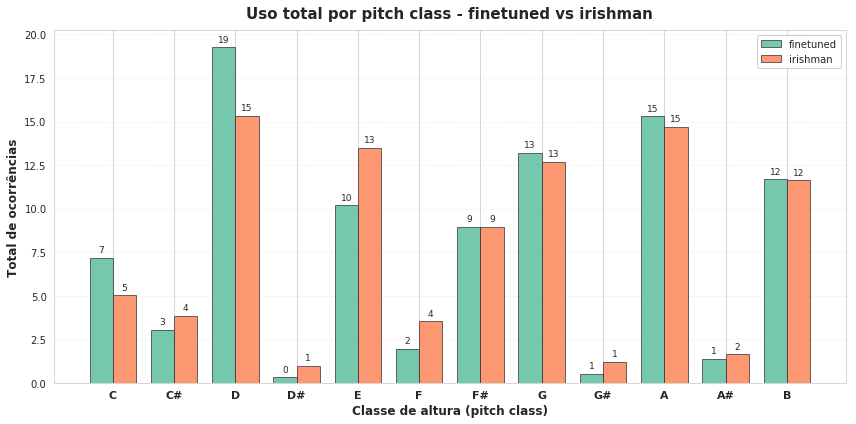

In [7]:
# Helper to coerce arrays to shape (n_samples, 12)
def _to_n_by_12(arr_like):
    arr = np.asarray(arr_like)
    if arr.ndim == 1:
        # If a single flattened vector, reshape to (n, 12) if divisible by 12
        if arr.size % 12 == 0:
            arr = arr.reshape(-1, 12)
        else:
            raise ValueError("total_pitch_class_histogram has unexpected 1D size: {}".format(arr.size))
    elif arr.ndim == 2:
        if arr.shape[1] == 12:
            pass  # (n, 12)
        elif arr.shape[0] == 12:
            arr = arr.T  # -> (n, 12)
        else:
            raise ValueError("total_pitch_class_histogram has unexpected 2D shape: {}".format(arr.shape))
    else:
        # Flatten batch dims except the last if it's 12
        if arr.shape[-1] == 12:
            arr = arr.reshape(-1, 12)
        else:
            raise ValueError("total_pitch_class_histogram has unexpected ndim/shape: {}".format(arr.shape))
    return arr

# Retrieve and normalize shapes
pc1 = _to_n_by_12(set1_loaded_results['total_pitch_class_histogram'])
pc2 = _to_n_by_12(set2_loaded_results['total_pitch_class_histogram'])

# Sum how many times each pitch class was used across all samples
counts1 = pc1.sum(axis=0)
counts2 = pc2.sum(axis=0)

pitch_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
x = np.arange(12)

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.38
colors = ['#66c2a5', '#fc8d62']

# Side-by-side grouped bars
ax.bar(x - width/2, counts1, width=width, label=MODEL_1, color=colors[0], alpha=0.9, edgecolor='#333333', linewidth=0.8)
ax.bar(x + width/2, counts2, width=width, label=MODEL_2, color=colors[1], alpha=0.9, edgecolor='#333333', linewidth=0.8)

# Aesthetics (ensure unicode-compatible text)
ax.set_xticks(x)
ax.set_xticklabels(pitch_names, fontsize=11, fontweight='bold')
ax.set_ylabel('Total de ocorrências', fontsize=12, fontweight='bold')
ax.set_xlabel('Classe de altura (pitch class)', fontsize=12, fontweight='bold')
ax.set_title('Uso total por pitch class - {} vs {}'.format(MODEL_1, MODEL_2), fontsize=15, fontweight='bold', pad=12)
ax.legend(frameon=True, framealpha=0.95)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Optional: annotate values on top of bars (comment out if cluttered)
max_val = float(max(counts1.max(), counts2.max())) if (counts1.size and counts2.size) else 0.0
offset = max_val * 0.01
for i in range(12):
    ax.text(x[i] - width/2, counts1[i] + offset, '{:.0f}'.format(counts1[i]), ha='center', va='bottom', fontsize=9)
    ax.text(x[i] + width/2, counts2[i] + offset, '{:.0f}'.format(counts2[i]), ha='center', va='bottom', fontsize=9)

fig.tight_layout()
plt.show()

In [8]:
set1_loaded_results['total_pitch_class_histogram'][0]

array([0.        , 0.05208333, 0.35416667, 0.        , 0.0625    ,
       0.        , 0.125     , 0.        , 0.        , 0.21875   ,
       0.        , 0.1875    ])